06_GoogleNet_mnist

In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import datasets,layers,models,optimizers,Sequential,metrics,losses,utils
#from sklearn import preprocessing
import sys,os
print(tf.__version__)
print(sys.version)

2.0.0
3.6.12 |Anaconda, Inc.| (default, Sep  9 2020, 00:29:25) [MSC v.1916 64 bit (AMD64)]


In [25]:
def data_normalize(train, test, scale=1):
    (x_train,y_train) = train
    (x_test,y_test) = test
    train_nums = x_train.shape[0] // scale
    test_nums = x_test.shape[0] // scale
    x_train, y_train = x_train[:train_nums], y_train[:train_nums]
    x_test, y_test = x_test[:train_nums], y_test[:train_nums]
    x_train = x_train.astype(np.float32) / 255.
    x_test = x_test.astype(np.float32) / 255.
    y_train = utils.to_categorical(y_train)#.astype(np.int32)
    y_test = utils.to_categorical(y_test)
    
    x_train = np.expand_dims(x_train, axis=-1)
    x_test = np.expand_dims(x_test, axis=-1)
    
    print(x_train.shape,y_train.shape)
    print(x_test.shape,y_test.shape)
    
    return (x_train,y_train),(x_test,y_test)

(x_train,y_train),(x_test,y_test) = datasets.mnist.load_data()
(x_train,y_train),(x_test,y_test) = data_normalize((x_train,y_train),(x_test,y_test), scale=10) 

(6000, 28, 28, 1) (6000, 10)
(6000, 28, 28, 1) (6000, 10)


In [20]:
class ConvBNRelu(models.Model):
    def __init__(self, filters, kernel_size=3, strides=1, padding='SAME'):
        super(ConvBNRelu, self).__init__()
        self.model = models.Sequential([
            layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding=padding),
            layers.BatchNormalization(),   # 增加Batch Normalization
            layers.ReLU()
        ])

    def call(self, inputs, training=None):
        inputs = self.model(inputs, training=training)
        return inputs
    
class InceptionBlock(models.Model):
    def __init__(self, filters, strides=1):
        super(InceptionBlock, self).__init__()
        self.filters = filters
        self.strides = strides
        self.conv1 = ConvBNRelu(filters, strides=strides)
        self.conv2 = ConvBNRelu(filters, kernel_size=3, strides=strides)
        self.conv3 = ConvBNRelu(filters, kernel_size=3, strides=strides)
        self.conv4 = ConvBNRelu(filters, kernel_size=3, strides=1)

        self.pool = layers.MaxPooling2D(pool_size=3, strides=1, padding='SAME')
        self.pool_conv = ConvBNRelu(filters, strides=strides)

    def call(self, inputs, training=None):
        x1 = self.conv1(inputs, training=training)
        x2 = self.conv2(inputs, training=training)
        x3 = self.conv3(inputs, training=training)
        x4 = self.conv4(x3, training=training)

        x5 = self.pool(inputs)
        x5 = self.pool_conv(x5, training=training)
        # 將四個卷積核疊加在一起
        x = tf.concat([x1, x2, x4, x5], axis=3)

        return x

class GoogleNet(models.Model):
    def __init__(self, num_layers, num_classes, init_channel=16, **kwargs):
        super(GoogleNet, self).__init__(**kwargs)

        self.input_channel = init_channel
        self.output_channel = init_channel
        self.num_classes = num_classes
        self.init_channel = init_channel

        self.conv1 = ConvBNRelu(init_channel)
        self.blocks = Sequential(name='dynamic-blocks')

        for block_id in range(num_layers):
            for layer_id in range(2):
                if layer_id == 0:
                    block = InceptionBlock(self.output_channel, strides=2)
                else:
                    block = InceptionBlock(self.output_channel, strides=1)

                self.blocks.add(block)
            # Increase output dimension per block
            self.output_channel *= 2

        self.avg_pool = layers.GlobalAveragePooling2D()
        self.fc = layers.Dense(num_classes)

    def call(self, inputs, training=None):
        out = self.conv1(inputs, training=None)
        out = self.blocks(out, training=None)
        out = self.avg_pool(out)
        out = self.fc(out)

        return out

# input_shape = (None,28,28,1)
# test_model = ConvBNRelu(filters=3)
# test_model = InceptionBlock(filters=3)
# test_model = GoogleNet(num_layers=2,num_classes=10)
# test_model.build(input_shape=input_shape)
# outputs = test_model(x_train[0:1])
# print(outputs.shape)

(1, 10)


In [22]:
# Inception = GoogleNet(5, 10)
# Inception.build(input_shape=(None, 28, 28, 1))
input_shape = (None,28,28,1)
model = GoogleNet(num_layers=2,num_classes=10)
model.build(input_shape=input_shape)
model.summary()

Model: "google_net_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_bn_relu_63 (ConvBNRelu) multiple                  224       
_________________________________________________________________
dynamic-blocks (Sequential)  multiple                  292704    
_________________________________________________________________
global_average_pooling2d_2 ( multiple                  0         
_________________________________________________________________
dense_2 (Dense)              multiple                  1290      
Total params: 294,218
Trainable params: 293,226
Non-trainable params: 992
_________________________________________________________________


In [26]:
batch_size = 256
optimizer = optimizers.Adam(lr=0.01)
loss_func = losses.CategoricalCrossentropy(from_logits=True)
model.compile(loss=loss_func, optimizer=optimizer, metrics=["accuracy"])
history = model.fit(x_train,y_train, batch_size=batch_size, epochs=4, verbose=1,validation_data=(x_test,y_test))

Train on 6000 samples, validate on 6000 samples
Epoch 1/4
6000/6000 [==============================] - 35s 6ms/sample - loss: 0.7742 - accuracy: 0.7785 - val_loss: 10.9304 - val_accuracy: 0.1602
Epoch 2/4
6000/6000 [==============================] - 32s 5ms/sample - loss: 0.1183 - accuracy: 0.9685 - val_loss: 10.4179 - val_accuracy: 0.1762
Epoch 3/4
6000/6000 [==============================] - 32s 5ms/sample - loss: 0.0657 - accuracy: 0.9813 - val_loss: 8.9324 - val_accuracy: 0.2127
Epoch 4/4
6000/6000 [==============================] - 31s 5ms/sample - loss: 0.0382 - accuracy: 0.9897 - val_loss: 5.5963 - val_accuracy: 0.2233


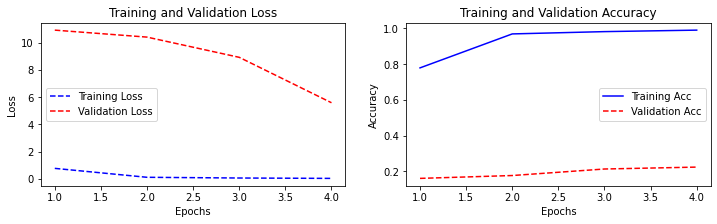

In [27]:
def visual_train_status(history):
        plt.figure(figsize=(12,3))
        loss = history.history["loss"]
        val_loss = history.history["val_loss"]
        epochs = range(1, len(loss)+1)  
        plt.subplot(1,2,1)
        plt.plot(epochs, loss, "b--", label="Training Loss")
        plt.plot(epochs, val_loss, "r--", label="Validation Loss")
        plt.title("Training and Validation Loss")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.legend()
        
        # 顯示訓練和驗證準確度
        acc = history.history["accuracy"]
        val_acc = history.history["val_accuracy"]
        epochs = range(1, len(acc)+1)
        plt.subplot(1,2,2)
        plt.plot(epochs, acc, "b-", label="Training Acc")
        plt.plot(epochs, val_acc, "r--", label="Validation Acc")
        plt.title("Training and Validation Accuracy")
        plt.xlabel("Epochs")
        plt.ylabel("Accuracy")
        plt.legend()
        plt.show()
        
visual_train_status(history)

Predictions
tf.Tensor([2 2 2 1 2 2 2 1 2 2], shape=(10,), dtype=int64)
Labels
tf.Tensor([6 0 5 4 9 9 2 1 9 4], shape=(10,), dtype=int64)
陸	零	伍	肆	玖	玖	貳	壹	玖	肆	


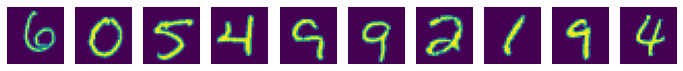

In [28]:
class_names = ["零","壹","貳","參","肆","伍","陸","柒","捌","玖"]
index = 100 # np.random.randint(900)
preds = model.predict(x_test[index:index+10])
preds = tf.argmax(preds, axis=1)
print("Predictions")
print(preds)
labels = y_test[index:index+10]
labels = tf.argmax(labels, axis=1)
print("Labels")
print(labels)
for i in range(10):
    print(class_names[labels[i]],end="\t")
print()
plt.figure(figsize=(12,2))
for i in range(10):
    plt.subplot(1,10,(i+1))
    plt.axis("off")
    plt.imshow(x_test[index+i])
plt.show()